# A/B Test

In [62]:
import pandas as pd
import numpy as np

Read in data

In [63]:
channel_name = 'aftv'
data = pd.read_csv(f'./{channel_name}_performance_statistics.csv')

In [64]:
data.head(3)

,date,title,views,likes,comments,team_score,opponent_score,result
0,2017-10-14,Watford 2-1 Arsenal | Arsenal Are Now Just An ...,169316,2824.0,746,1.0,2.0,loss
1,2017-10-15,Watford 2-1 Arsenal | I've Supported Arsenal S...,60090,1125.0,132,1.0,2.0,loss
2,2017-10-19,Red Star Belgrade 0 -1 Arsenal | It's Time To ...,419796,6314.0,948,1.0,0.0,win


### Calculate metrics

In [65]:
data['like_ratio'] = data['likes']/data['views']
data['comment_ratio'] = data['comments']/data['views']

In [66]:
#data.head()

### Split data into wins and losses 

In [67]:
wins = data[data['result'] == 'win']
losses = data[data['result'] == 'loss']

In [68]:
wins_likes = wins[['like_ratio']]
wins_comments = wins[['comment_ratio']]

In [69]:
loss_likes = losses[['like_ratio']]
loss_comments = losses[['comment_ratio']]

### Sample size

Estimating the number of samples needed to detect a difference in metrics

In [70]:
sum(wins['views']), sum(losses['views'])

(39456036, 39213893)

In [71]:
import statsmodels.stats.api as sms

look for a 20% increase in the baseline rate

In [72]:
bcr_likes = 0.02
bcr_comments = 0.005
increase = 1.2

In [73]:
effect_size_likes = sms.proportion_effectsize(bcr_likes, increase*bcr_likes)
effect_size_comments = sms.proportion_effectsize(bcr_comments, increase*bcr_comments)

In [74]:
effect_size_likes, effect_size_comments

(-0.02729749258363351, -0.013535199639911177)

In [75]:
required_views_likes = sms.NormalIndPower().solve_power(
    effect_size_likes, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )

In [76]:
required_views_comments = sms.NormalIndPower().solve_power(
    effect_size_comments, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )

In [77]:
required_views_likes, required_views_comments

(21066.437206055296, 85685.48805649913)

- For like_ratio: using a baseline like rate of 2%, minimum detectable effect of a 20% increase, significance level of 5%, and power of 80%, we need a sample size of at least <code>required_views_likes</code> views

- For comment_ratio: using a baseline comment rate of 0.5%, minimum detectable effect of 20% increase, significance level of 5%, and power of 80%, we need a sample size of at least <code>required_views_comments</code> views

# Distributions

In [78]:
from matplotlib import pyplot as plt
import seaborn as sns

In [79]:
def plot_dist(wins, losses, col, channel_name,kde=True, save_fig=False):
    '''
    Plot histogram and density curve of a given metric
    Args:
        col: column name of metric
    '''
    fig, ax1 = plt.subplots()
    sns.distplot(wins[col], color='g', label='wins', kde=kde, ax=ax1);
    sns.distplot(losses[col], color='r', label='losses',kde=kde, ax=ax1);
    ax1.legend(loc='upper right');
    title = col.replace("_", " ")
    ax1.set_title(f'{channel_name.upper()}: {title} distibution')
    if save_fig:
        plt.savefig(f'{channel_name}_{col}_dist.png')

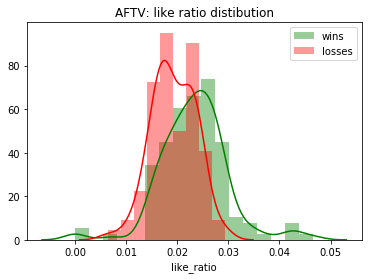

In [80]:
plot_dist(wins, losses, 'like_ratio', channel_name, save_fig=True)

The like ratio estimate is not far from the literature

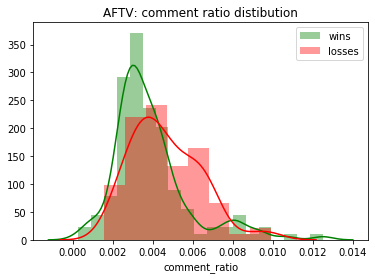

In [81]:
plot_dist(wins, losses, 'comment_ratio', channel_name, kde=True, save_fig=True)

The comment ratio also seems to agree with the literature

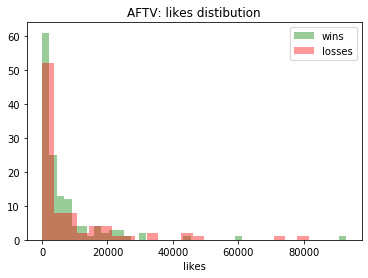

In [82]:
plot_dist(wins, losses, 'likes', channel_name, kde=False)

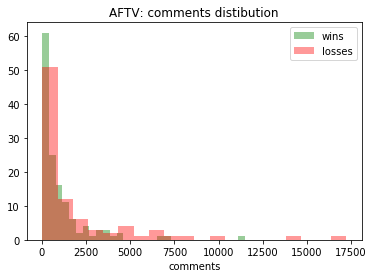

In [83]:
plot_dist(wins, losses, 'comments', channel_name, kde=False)

Like and comments follow poisson distribution as expected

<h1>A/B test</h1>

The Null hypothesis $\left(H_0\right)$ is that there is no difference in the like and comment ratios for wins and losses. 

The alternative hypothesis $\left(H_a\right)$ is that there is a difference between these ratios for wins and losses

<h2>Pythonic method</h2>
<p>Using scipy </p>

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

In [84]:
from scipy.stats import ttest_ind

Set equal variance to False? We have very different sample sizes for wins and losses and it is very likely that the variance within groups is different. However setting to true or false does not change p-value significantly

In [85]:
tstat, pval_likes = ttest_ind(wins_likes.values, loss_likes.values, equal_var=True)

In [86]:
tstat, pval_comments = ttest_ind(wins_comments.values, loss_comments.values, equal_var=True)

In [87]:
print(f'The pvalue for like/views ratio is {pval_likes[0]}')

The pvalue for like/views ratio is 6.69231246487344e-07


In [88]:
print(f'The pvalue for like/comments ratio is {pval_comments[0]}')

The pvalue for like/comments ratio is 0.0045425939636976375


<h2>Manual method</h2>

The Null hypothesis is that there is no difference between the metrics for wins and losses

$H_0: \hat{d}_i = 0$,

where $\hat{d}_i$ is the metric i.e. like_ratio or comment_ratio. This difference
should follow a normal distribution with the pooled standard error

$\hat{d}_i \sim \mathcal{N}(0,\,SE_{pool})$


For metrics which follow a normal distribution, we can calculate the standard error using the following formula,

$SE_{pool} = \sqrt{\hat{p}_{pool} (1-\hat{p}_{pool}) \left(\frac{1}{N_c} + \frac{1}{N_e}\right)}$

where the pooled statistic is calculated like the below

$\hat{p}_{pool} = \frac{\text{likes}_{wins} + \text{likes}_{losses}}{N_{wins} + N_{losses}}$

For non-normal distributions, we can use the empirical estimate of the metric to determine the standard error of the experiment using the folowing formula

$\frac{SE_{exp}}{\sqrt{\frac{1}{N_c} + \frac{1}{N_e}}} = \frac{SE_{empirical}}{\sqrt{\frac{1}{N_c} + \frac{1}{N_e}}}$,

here N = number of views


In [89]:
def test_hypothesis(ctrl, exp, num, den, bcr, zscore=1.96, dist='normal', size=100000):
    '''
    Test if the Null hypothesis i.e. no difference between control and experiment
    is likely.
    
    If the range of the difference between control and experiment metric does not 
    include 0 then reject the Null
    
    Args:               
        ctrl: data for control group (wins)
        exp: data for experiment group (losses)
        num: numerator for metric calculation
        den: denominator for metric calculation
        bcr: empirical baseline rate 
        zscore: z* for confidence interval (1.96 => 95%)        
        dist: determines what formula is used to calc standard error
        size: sample size used for empirical estimate. Assume 100K
    
    
    '''
    
    print(f'No of control samples= {len(ctrl)}, views= {sum(ctrl[den])}')
    print(f'No of experiment samples= {len(exp)}, views= {sum(exp[den])}')
    
    p_ctrl = sum(ctrl[num])/sum(ctrl[den])
    p_exp = sum(exp[num])/sum(exp[den])
    
    print(f'\ncontrol statistic = {p_ctrl}')
    print(f'experiment statistic = {p_exp}')
    
    p_pool = (sum(ctrl[num]) + sum(exp[num]))/(sum(exp[den]) + sum(ctrl[den]))
    print(f'pooled statistic = {p_pool}')
    
    dhat = p_exp - p_ctrl
    print(f'dhat = {dhat}')
    
    if dist == 'normal':
        se = np.sqrt( ( p_pool*(1-p_pool) ) * ( 1./sum(exp[den]) + 1./sum(ctrl[den]) ) )        
    else:
        se = (bcr*np.sqrt((1/sum(exp[den])) + (1/sum(ctrl[den]))))/np.sqrt((1/size) + (1/size))        
    
    me = zscore * se
    print(f'The standard error is = {se}')
    print(f'The margin of error is = {me}')
    
    upper_bound = dhat + me
    lower_bound = dhat - me
    print(f'\nThe range expected is: \n{lower_bound} - {upper_bound}\n')    
    
    if not (lower_bound <=  0 <= upper_bound):
        print(f'0 does not lie within the expected range based on the confidence level')
        print('\n***Reject the Null Hypothesis***')                
    else:
        print(f'dhat lies in the expected range based on the confidence level')      
        print('\n***Fail to reject the Null***')
    

In [90]:
test_hypothesis(ctrl=wins, exp=losses, num='likes', den='views', bcr=0.02)

No of control samples= 138, views= 39456036
No of experiment samples= 87, views= 39213893

control statistic = 0.02419670338905814
experiment statistic = 0.019826544638146485
pooled statistic = 0.022018349603442504
dhat = -0.004370158750911655
The standard error is = 3.308913456531181e-05
The margin of error is = 6.485470374801115e-05

The range expected is: 
-0.004435013454659666 - -0.004305304047163644

0 does not lie within the expected range based on the confidence level

***Reject the Null Hypothesis***


<font color='red'> For comments, don't use binomial formula for the standard error</font>

In [91]:
test_hypothesis(ctrl=wins, exp=losses, num='comments', den='views', bcr=0.005, dist='p')

No of control samples= 138, views= 39456036
No of experiment samples= 87, views= 39213893

control statistic = 0.0035837102338410276
experiment statistic = 0.004211288075886778
pooled statistic = 0.003896533324696403
dhat = 0.0006275778420457507
The standard error is = 0.0002521057088773186
The margin of error is = 0.0004941271893995444

The range expected is: 
0.0001334506526462063 - 0.001121705031445295

0 does not lie within the expected range based on the confidence level

***Reject the Null Hypothesis***
